# Cleaning Data
_This notebook resolves missing data on the train and test dataset, then converts categorical columns to numerical columns where that applies._

In [1]:
# Importing libraries
import pandas as pd
import numpy as np
import seaborn as sns
import missingno as msno
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

In [2]:
train = pd.read_csv('../datasets/train.csv')
test = pd.read_csv('../datasets/test.csv')

## Taking a preliminary look at the data
Checking out the first few rows of the train and test dataset; looking at dataframe shape to see number of rows and columns in each.

In [3]:
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [4]:
test.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [5]:
# There are 1460 rows in the train data
train.shape

(1460, 81)

In [6]:
# There are 1459 rows in the test data
test.shape

(1459, 80)

## Imputing Missing Values
Strategy: Looking at the missing values in each column, will attempt to impute missing values in columns where there is a significant amount of missing data. However, if there is only one or two missing values in the column, will leave those until the very end and see if dropping whole rows with any missing values will significantly impact data (it might be the case that there might be certain rows that have a large amount of missing values in general).

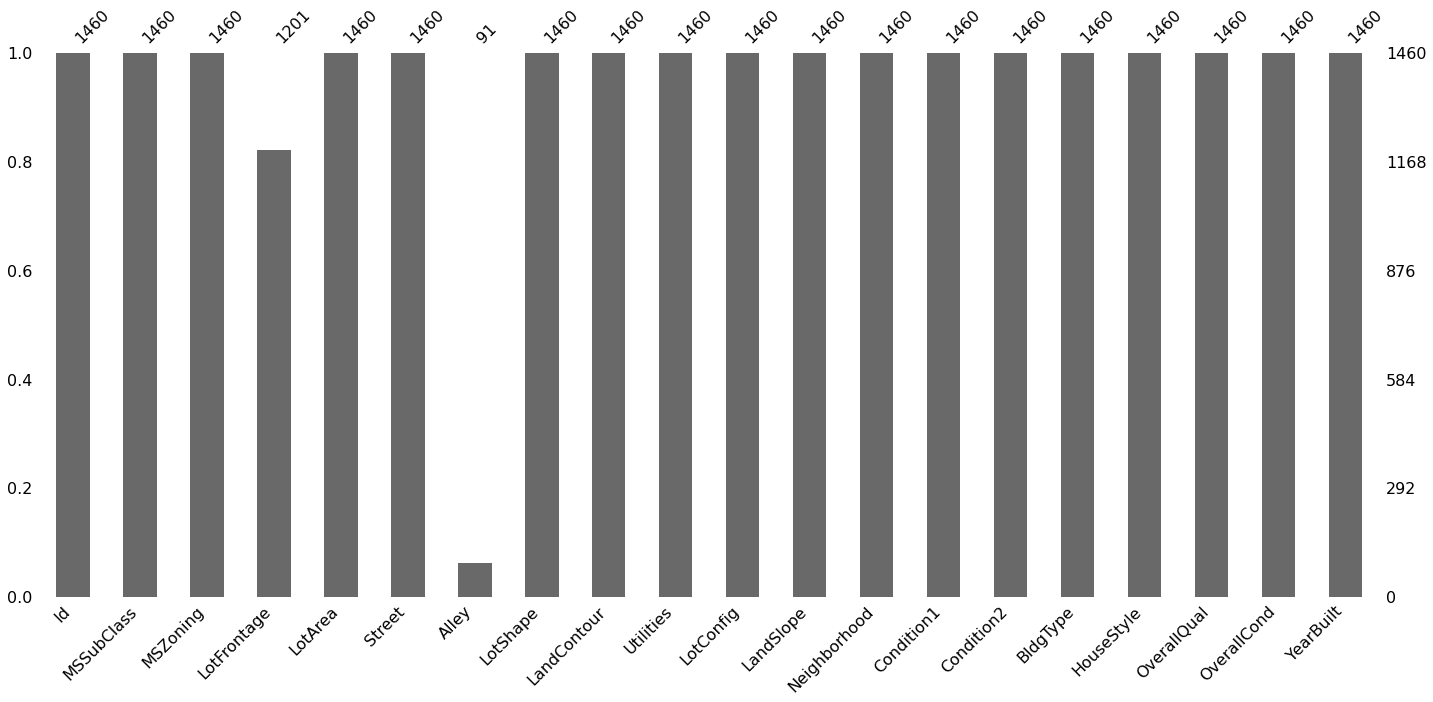

In [7]:
# Used the MissingNo library to help visualize missing values
# Let's start by looking at the first 20 columns of the train and test data

# train data
msno.bar(train[train.columns[:20]]);

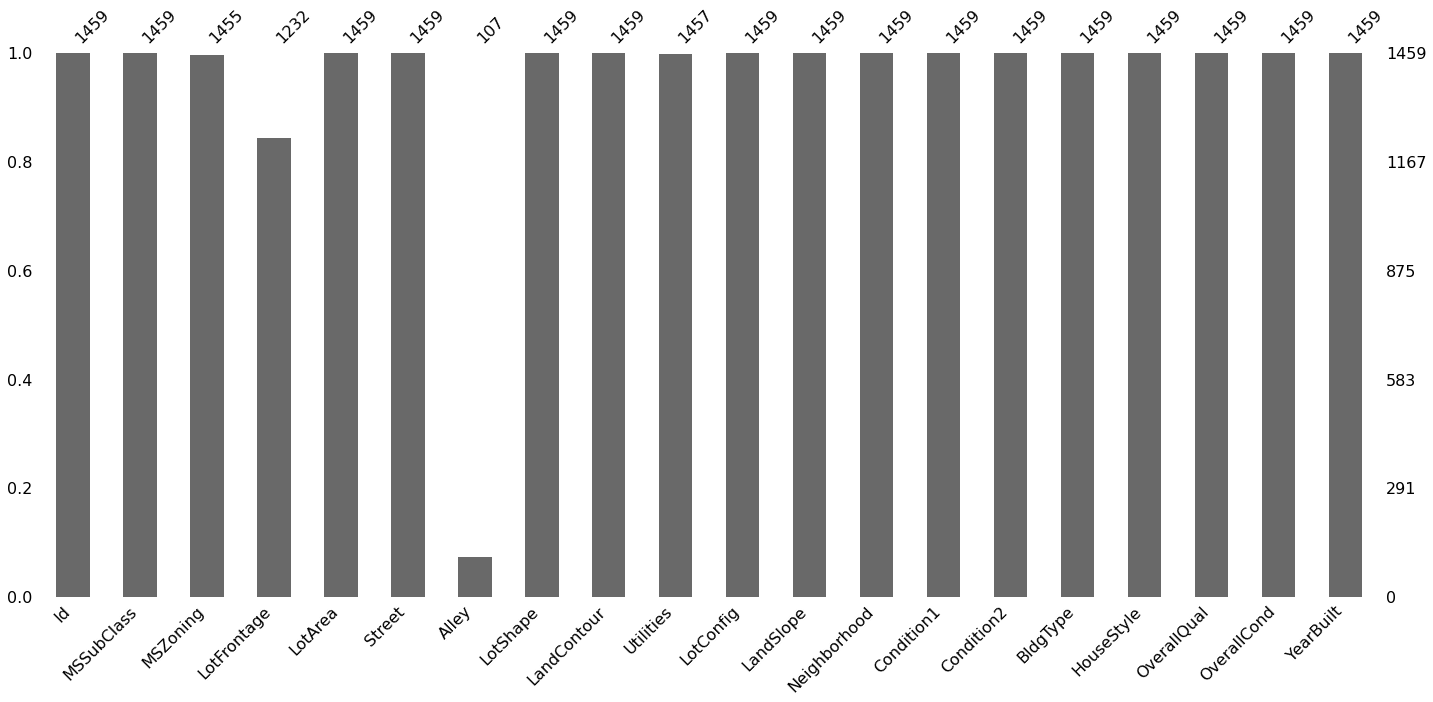

In [8]:
# test data
msno.bar(test[test.columns[:20]]);

_LotFrontage and Alley have a few NaN entries in the train dataset. MSZoning and Utilities have a few NaN entries in the test dataset. Let's take a closer look at those columns._

In [9]:
# Alley column
train['Alley'].value_counts(dropna=False)

NaN     1369
Grvl      50
Pave      41
Name: Alley, dtype: int64

_Looking at the data dictionary provided, it seems that some houses do not have an alley near the house. So, I filled those missing values with 'None'. Did the same for the test data._

In [10]:
# Filling NA values with 'None'
train['Alley'] = train['Alley'].fillna('None')
test['Alley'] = test['Alley'].fillna('None')

In [11]:
# Lot Frontage column
train['LotFrontage'].describe()

count    1201.000000
mean       70.049958
std        24.284752
min        21.000000
25%        59.000000
50%        69.000000
75%        80.000000
max       313.000000
Name: LotFrontage, dtype: float64

_Lot Frontage is missing values. The data dictionary doesn't have any information on why those values were missing, so I used LotArea to extrapolate values from a linear regression._

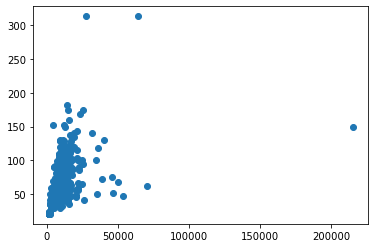

In [12]:
# Using a scatterplot shows that Lot Area and Lot Frontage have a pretty high correlation
plt.scatter(train['LotArea'], train['LotFrontage']);

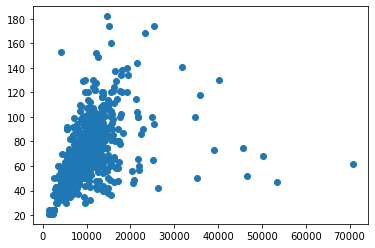

In [13]:
# creating a dataframe from Lot Area and Lot Frontage and dropping NA values
lot_regression = train[['LotArea','LotFrontage']].dropna()

# excluding some of the outliers for a better performing linear regression
lot_regression = lot_regression[lot_regression['LotArea'] < 100000]
lot_regression = lot_regression[lot_regression['LotFrontage'] < 200]

# scatterplot with outliers excluded
plt.scatter(lot_regression['LotArea'], lot_regression['LotFrontage']);

In [14]:
# Initializing the linear regression model
lr = LinearRegression()

# Reshaping since linearRegression takes a matrix
lr.fit(lot_regression['LotArea'].values.reshape(-1, 1), 
       lot_regression['LotFrontage'])

# Evaluating the model
# R-squared score
lr.score(lot_regression['LotArea'].values.reshape(-1, 1), 
         lot_regression['LotFrontage'])

# Lot Area explains 24% of the variability in Lot Frontage

0.23811479423482096

_Next, I created a function that will help fill in the missing values of Lot Frontage with a prediction from the LinearRegression model created above._

In [15]:
def pred_lot_front(xy):
    x = xy[0]
    y = xy[1]
    if y > 0:
        return y
    else:
        return lr.coef_[0] * x + lr.intercept_

In [16]:
# Fill NANs with 0, then apply function to fill in values of 0. Did the same for the test data.
train['LotFrontage'] = train['LotFrontage'].fillna(0)
train['LotFrontage'] = train[['LotArea', 'LotFrontage']].apply(pred_lot_front, axis = 1)

test['LotFrontage'] = test['LotFrontage'].fillna(0)
test['LotFrontage'] = test[['LotArea', 'LotFrontage']].apply(pred_lot_front, axis = 1)

In [17]:
# A look at MSZoning values in the test data
test['MSZoning'].value_counts(dropna=False)

RL         1114
RM          242
FV           74
C (all)      15
RH           10
NaN           4
Name: MSZoning, dtype: int64

In [18]:
# Since majority of values are 'RL', will just full in the NaN values with that class
test['MSZoning'] = test['MSZoning'].fillna('RL')

In [19]:
# A look at Utilities values in the test data
test['Utilities'].value_counts(dropna=False)

AllPub    1457
NaN          2
Name: Utilities, dtype: int64

In [20]:
# Since every filled value is 'AllPub', will impure NaNs with that class
test['Utilities'] = test['Utilities'].fillna('AllPub')

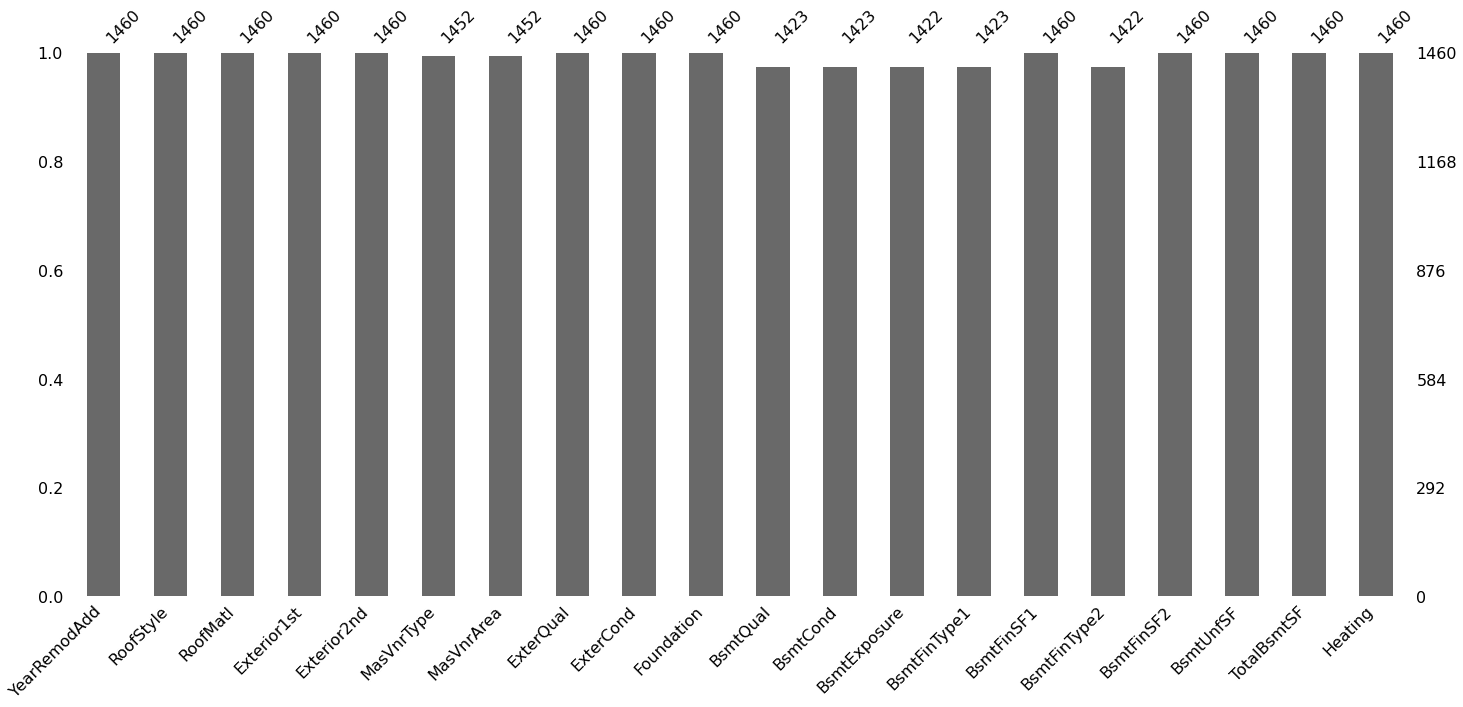

In [21]:
# Looking at missing values for columns 20 to 39
# train data
msno.bar(train[train.columns[20:40]]);

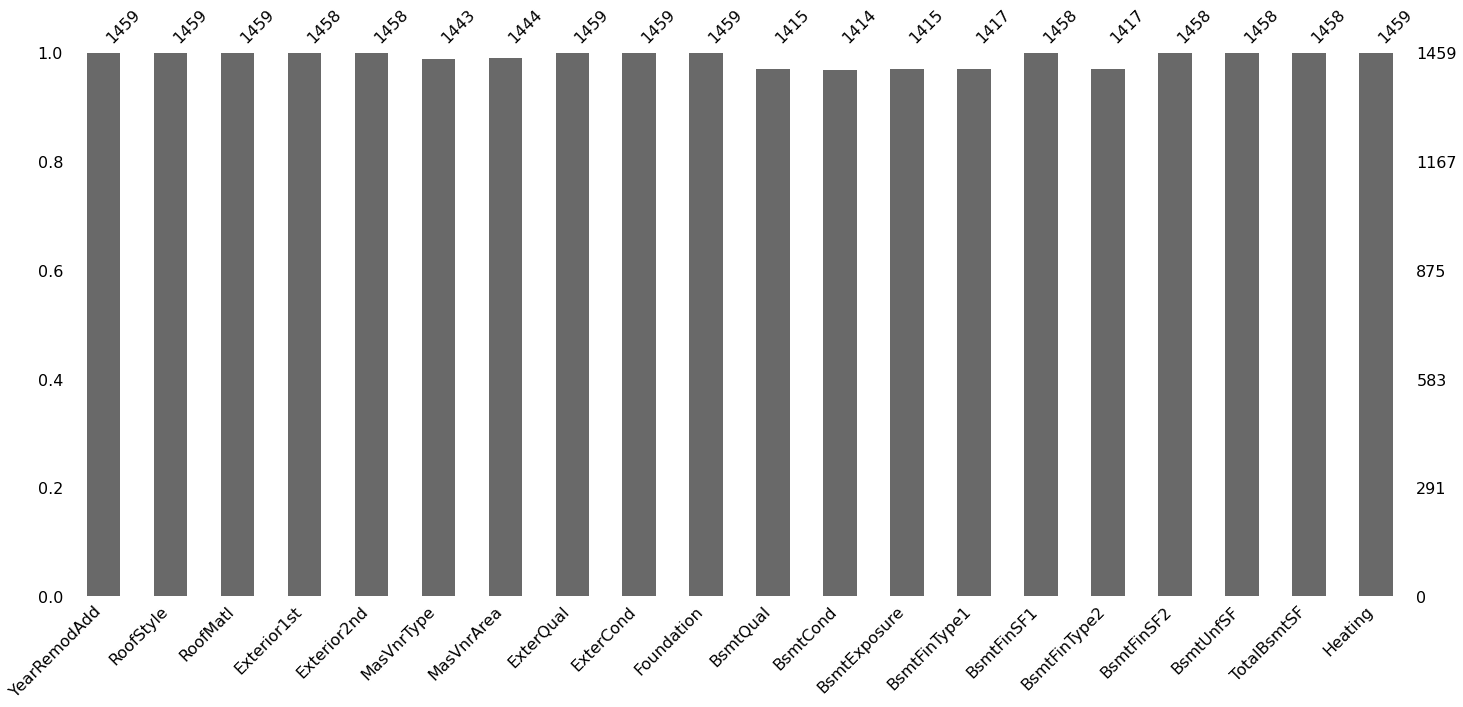

In [22]:
#test data
msno.bar(test[test.columns[20:40]]);

_It seems that there are missing values for the 'MasVnrType', 'MasVnrArea', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', and 'BsmtFinType2' columns in both datasets._

In [23]:
train['MasVnrType'].value_counts(dropna=False)

None       864
BrkFace    445
Stone      128
BrkCmn      15
NaN          8
Name: MasVnrType, dtype: int64

_Since most of the Masonry Veneer Types area 'None', I decided to fill the missing values with 'None' as well._

In [24]:
# Filled NaNs with 'None'. Doing the same for the test data.
train['MasVnrType'] = train['MasVnrType'].fillna('None')
test['MasVnrType'] = test['MasVnrType'].fillna('None')

In [25]:
# Statistics of 'MasVnrArea' shows that most of the data has an area of 0. Will fill NaNs with 0.
train['MasVnrArea'].describe()

count    1452.000000
mean      103.685262
std       181.066207
min         0.000000
25%         0.000000
50%         0.000000
75%       166.000000
max      1600.000000
Name: MasVnrArea, dtype: float64

In [26]:
# Filled NaNs in train and test datasets with 0
train['MasVnrArea'] = train['MasVnrArea'].fillna(0)
test['MasVnrArea'] = test['MasVnrArea'].fillna(0)

_The columns concerning basements are 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', and 'BsmtFinType2'. Looking at the data dictionary, the "NA" entries were interpreted by Python to be NaNs. Impute with "None" instead._

In [27]:
# imputing basement column NaNs with string 'None' for both train and test`
bsmt_columns = ['BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2']
for i in bsmt_columns:
    train[i] = train[i].fillna('None')
    test[i] = test[i].fillna('None')

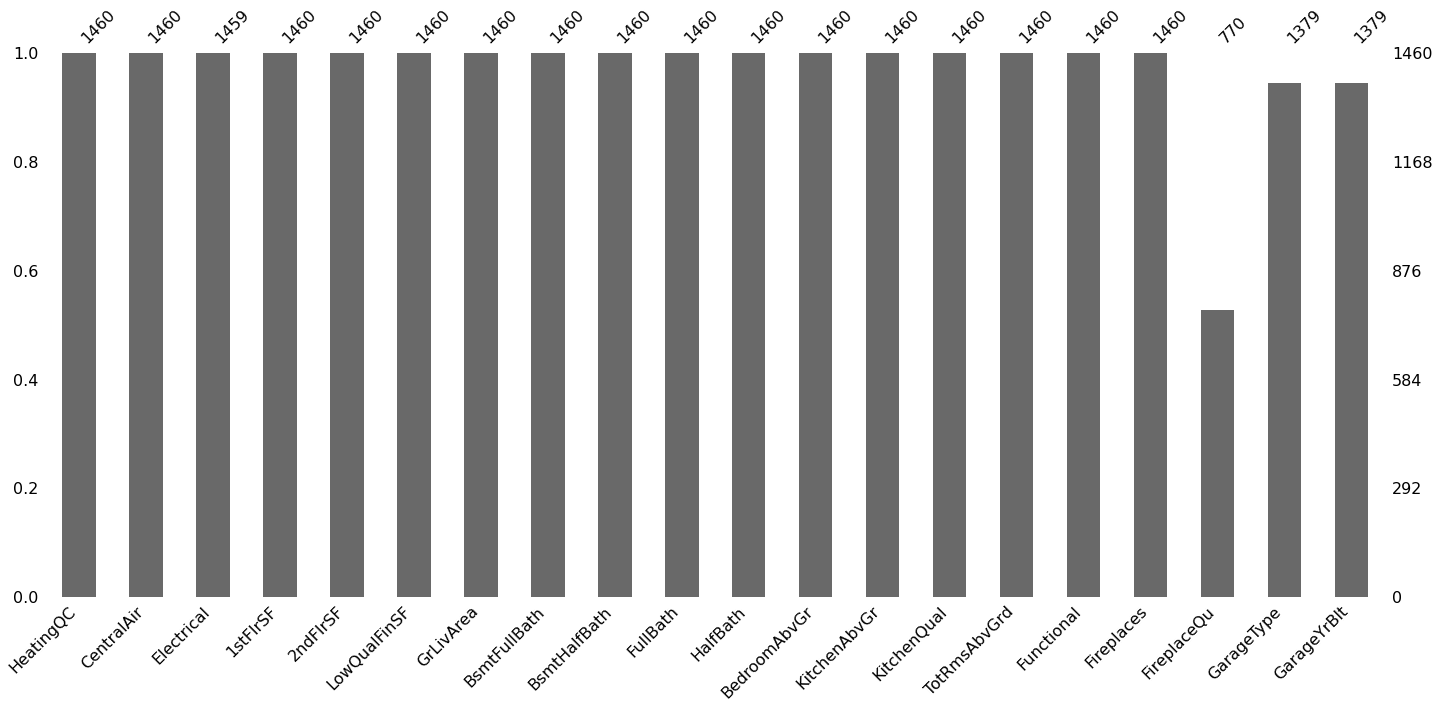

In [28]:
# Looking at missing values from columns 40 to 59
# train data
msno.bar(train[train.columns[40:60]]);

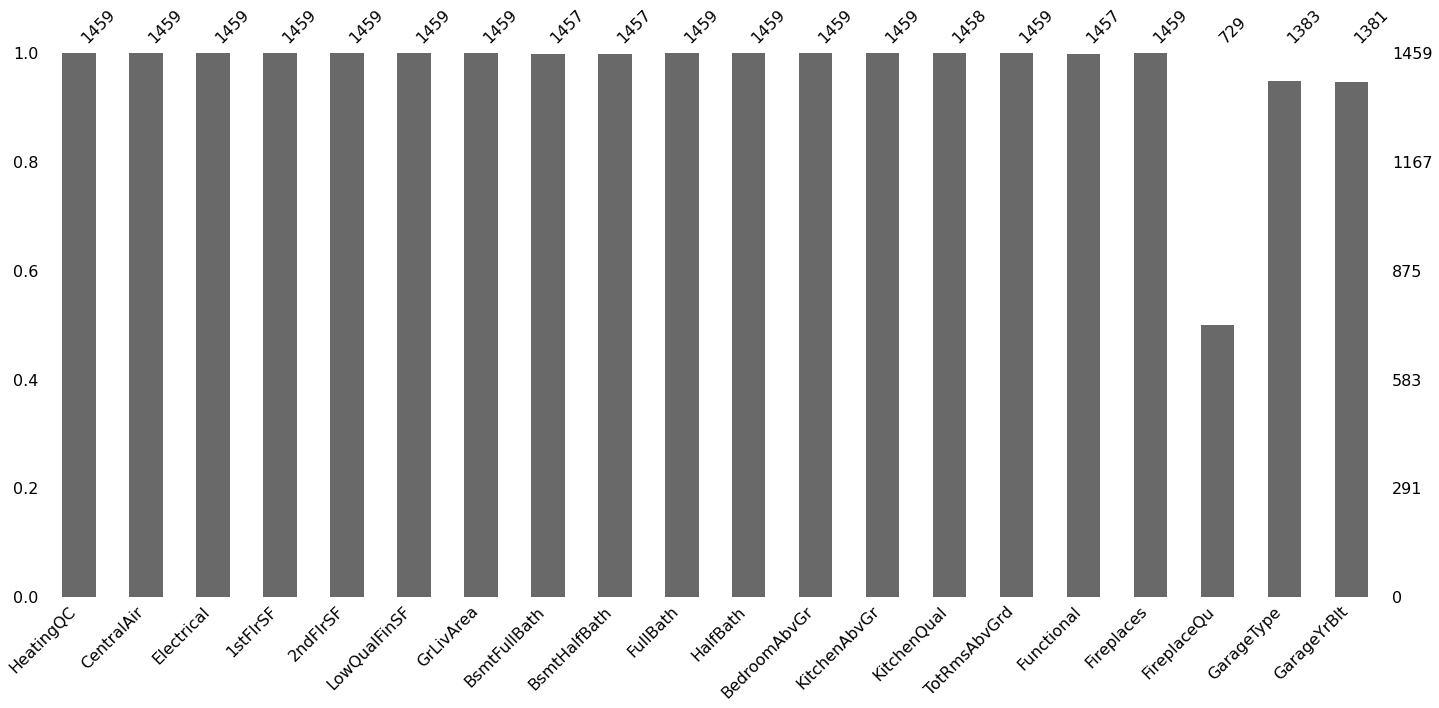

In [29]:
# test data
msno.bar(test[test.columns[40:60]]);

_'FireplaceQu', 'GarageType', and 'GarageYrBLt' are missing many values for both datasets. Looking at the data dictionary for 'Fireplace Qu' and 'GarageType', Python interpreted the 'NA' values to be missing. I replaced those with "None"._

In [30]:
columns = ['FireplaceQu', 'GarageType']
for col in columns:
    train[col] = train[col].fillna('None')
    test[col] = test[col].fillna('None')

In [31]:
# Missing values in GarageYrBlt are for houses without garages. Will fill with 0.
train['GarageYrBlt'] = train['GarageYrBlt'].fillna(0)
test['GarageYrBlt'] = test['GarageYrBlt'].fillna(0)

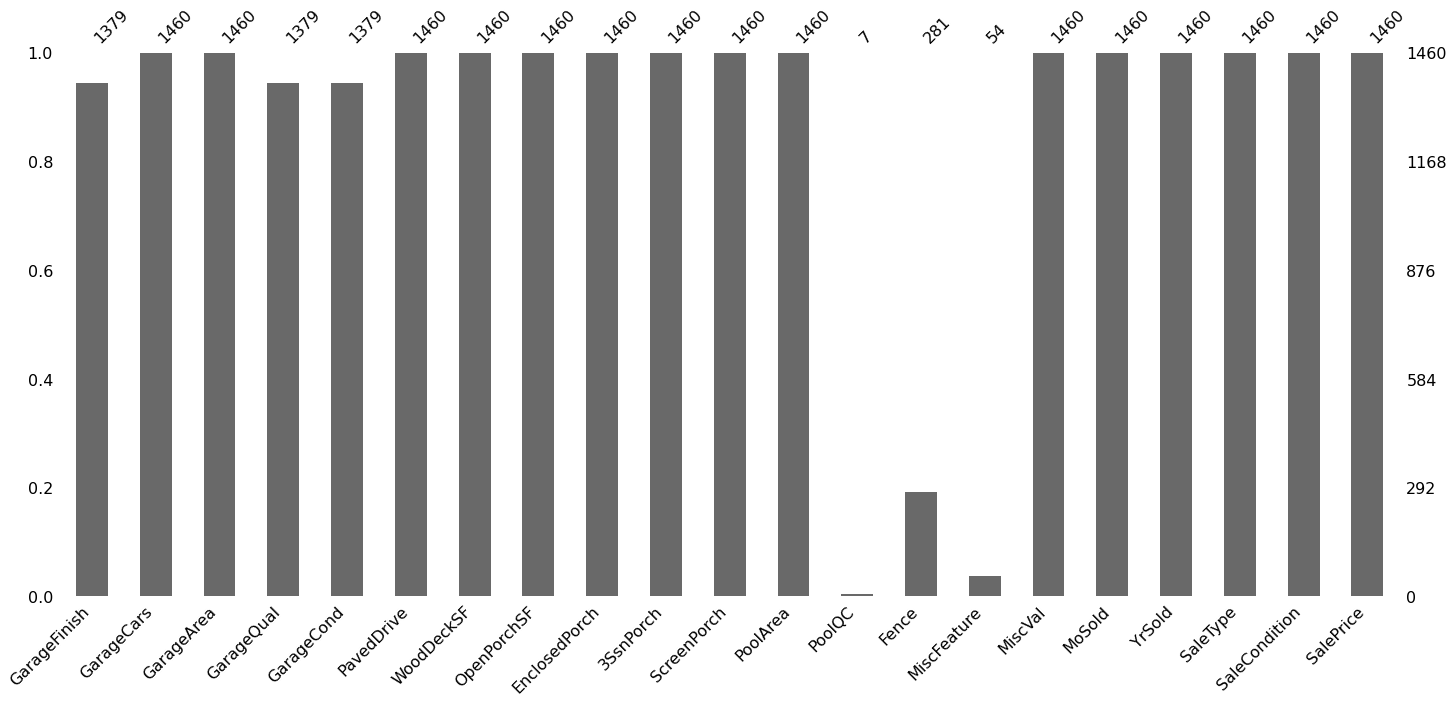

In [32]:
# Looking at missing values from columns 61 to 81
# train data
msno.bar(train[train.columns[60:]]);

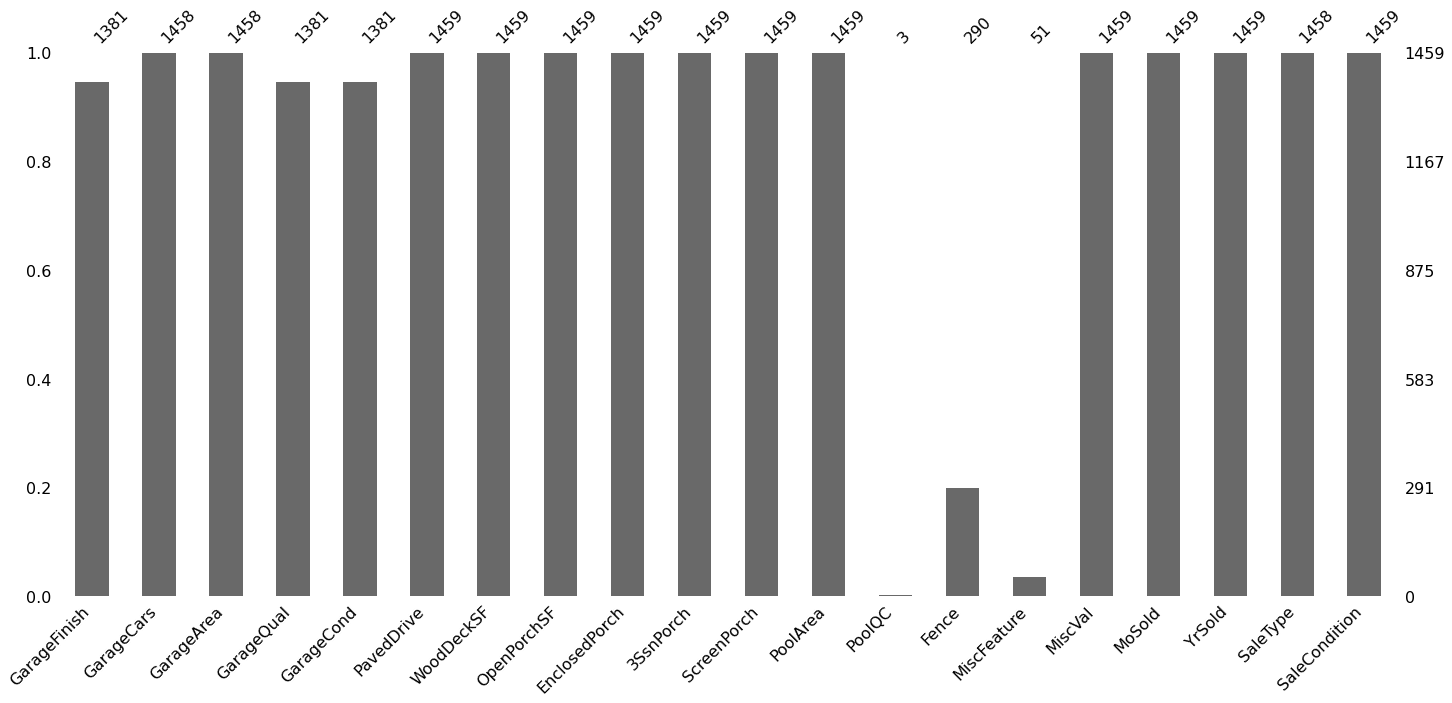

In [33]:
# test data
msno.bar(test[test.columns[60:]]);

_'GarageFinish', 'GarageQual', and 'GarageCond' are missing values in both datasets. However, these correspond to houses without garages. Will fill in 'None' 
for those missing values. 'PoolQC', 'Fence', and 'MiscFeature' are heavily missing in both datasets. Like the garage features, the missing values mean there is no pool, fence, etc. on the house. Will fill in 'None' for those missing values, as well._

In [34]:
columns = ['GarageFinish', 'GarageQual', 'GarageCond', 'PoolQC', 'Fence', 'MiscFeature']
for col in columns:
    train[col] = train[col].fillna('None')
    test[col] = test[col].fillna('None')

_Now that cleaning on columns with many missing values is complete, will see how much data is lost overall when we drop all rows with any missing data._ 

In [35]:
print(f'Lose {len(train) - len(train.dropna())} row(s) in train dataset out of {len(train)} rows')

Lose 1 row(s) in train dataset out of 1460 rows


In [36]:
print(f'Lose {len(test) - len(test.dropna())} row(s) in test dataset out of {len(test)} rows')

Lose 8 row(s) in test dataset out of 1459 rows


_Seeing as data loss is minimal at this point, will go ahead and drop rows with any missing values._

In [37]:
train = train.dropna()
test = test.dropna()

## Converting Categorical Columns to Numerical Columns
Strategy: Many of the columns have categorical descriptors where numerical values would suffice. This conversion will also be beneficial to the modeling process over one-hot encoding, since the values of these categorical descriptors can be placed on a scale.

_There are some general descriptors, and some descriptors that are specific to the column. Using the data dictionary provided, created a numerical conversion for each of these columns._

In [38]:
# Many columns use this generic scale
def generic(x):
    if x == 'Ex':
        return 5
    elif x == 'Gd':
        return 4
    elif x == 'TA':
        return 3
    elif x =='Fa':
        return 2
    else:
        return 1

# conversion for the 'FinType' column
def fin_type(x):
    if x == 'GLQ':
        return 6
    elif x == 'ALQ':
        return 5
    elif x == 'BLQ':
        return 4
    elif x == 'Rec':
        return 3
    elif x == 'LwQ':
        return 2
    elif x == 'Unf':
        return 1
    else:
        return 0

# conversion for the 'Functional' column
def functional(x):
    if x == 'Typ':
        return 7
    elif x == 'Min1':
        return 6
    elif x == 'Min2':
        return 5
    elif x == 'Mod':
        return 4
    elif x == 'Maj1':
        return 3
    elif x == 'Maj2':
        return 2
    elif x == 'Sev':
        return 1
    else:
        return 0

# conversion for the 'GarageFinish' column
def garage_finish(x):
    if x == 'Fin':
        return 3
    elif x == 'RFn':
        return 2
    elif x == 'Unf':
        return 1
    else:
        return 0

In [39]:
# Generic conversions
generic_columns = ['ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'HeatingQC', 'KitchenQual', 'FireplaceQu', 'GarageQual', 'GarageCond', 'PoolQC']
for col in generic_columns:
    train.loc[:, col] = train[col].apply(generic)
    test.loc[:, col] = test[col].apply(generic)

In [40]:
# FinType conversions
fintype_columns = ['BsmtFinType1', 'BsmtFinType2']
for col in fintype_columns:
    train.loc[:, col] = train[col].apply(fin_type)
    test.loc[:, col] = test[col].apply(fin_type)

In [41]:
# Functional conversion
train.loc[:, 'Functional'] = train['Functional'].apply(functional)
test.loc[:, 'Functional'] = test['Functional'].apply(functional)

In [42]:
# GarageFinish conversion
train.loc[:, 'GarageFinish'] = train['GarageFinish'].apply(garage_finish)
test.loc[:, 'GarageFinish'] = test['GarageFinish'].apply(garage_finish)

_On the other hand, we have 'MSSubClass' which is a numerical column but should be treated as a categorical column as per the data dictionary. Will convert to an object column to later be one-hot encoded._

In [43]:
train['MSSubClass'] = train['MSSubClass'].astype(str)

## One-hot Encoding of Categorical columns
Strategy: Will convert categorical columns to one-hot encoded columns, as categorical columns are unusable by machine learning models.

In [44]:
train.shape

(1459, 81)

In [45]:
# Using pd.get_dummies() to produce dummy columns for every categorical feature
train = pd.get_dummies(train)
test = pd.get_dummies(test)

_One-hot encoding causes some features to be exclusive to the train or test dataset. Will have to remove columns that are not in both, in order for the model to be able to predict on the test dataset._

In [46]:
available_columns = []
for col in train.columns:
    if col in test.columns:
        available_columns.append(col)

In [47]:
# limiting both train and test datasets to only include columns that exist in both
# first have to set aside the 'SalePrice' column in the train dataset, as that is not on the test dataset
target = train['SalePrice']

# only getting the columns that exist in both datasets
test = test[available_columns]
train = train[available_columns]

# re-add SalePrice to train data
train['SalePrice'] = target

_At this point, I'll save a copy of the train and test data to build out a more basic, explainable model using linear regression. The next steps of feature engineering will be used to make a highly performant model as a proof-of-concept. However, creating a deployable version of this advanced model will be tackled at a later time._

In [48]:
train.to_csv('../datasets/train_clean.csv', index=False)
test.to_csv('../datasets/test_clean.csv', index=False)

## Feature Correlation and Selection
Strategy: Look at correlations between each of the features and the target, SalePrice. Limit the list with a threshold. Choose columns that are most highly correlated to SalePrice to build model.

In [50]:
# get correlation values of each column to 'SalePrice'
correlations = abs(train.corr()['SalePrice']).sort_values(ascending=False)

# determine a threshold that the absolute correlation value must be greater than to be included 
threshold = 0.3

# created a dataframe of the columns and their correlations to 'SalePrice' that were above the threshold
correlations = pd.DataFrame(train.corr()['SalePrice'][abs(train.corr()['SalePrice']) > threshold].sort_values(ascending=False))

_Let's visualize the correlations of the columns to 'SalePrice' in a one-dimensional heatmap._

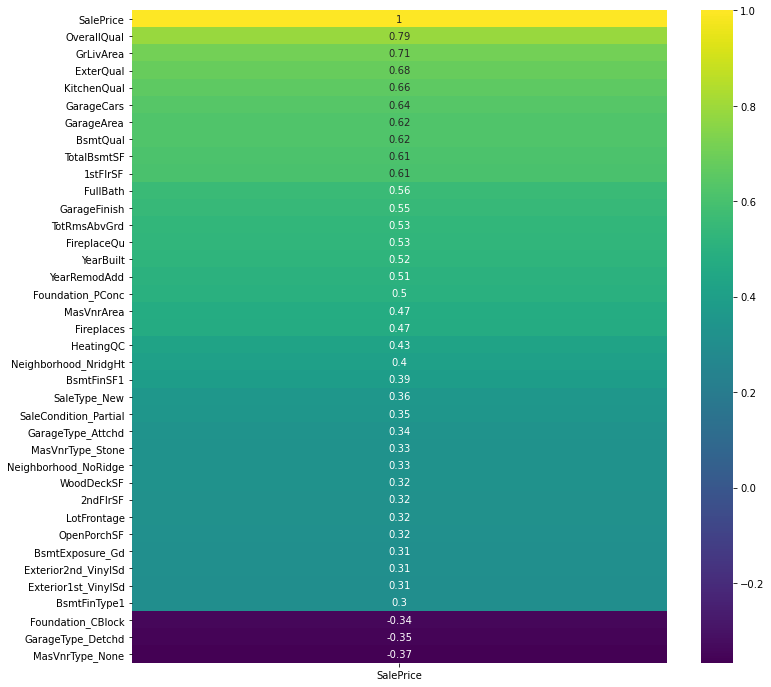

In [51]:
# set visualization size
plt.figure(figsize=(12,12))

# Assign the matplotlib axis the function returns. This will let us resize the labels.
sns.heatmap(correlations, annot = True, cmap='viridis')

# save figure
plt.savefig('../images/correlation.png')
plt.show()

_Some interesting observations:_
- It seems that many of the features that address quality (ie. of the exterior, the kitchen, etc.) have high correlation to the SalePrice. 
- Other features that are highly correlated make a lot of sense, such as 'GrLivArea' which is the square footage above ground in the house and 'GarageCars' which shows how large the garage of the house is (and even if these is one). 
- One strongly negatively correlated column is 'GarageType_Detchd', which is whether or not the garage of the house is detached. Another is 'MasVnrType_None' which is whether a house has any masnory veneer. If the house has none, then that brings down the 'SalePrice'.

## Recommendations for Modeling
_These features are the ones that will be used to create the model._

In [57]:
# determine a threshold that the absolute correlation value must be greater than to be included 
threshold = 0.5

# created a dataframe of the columns and their correlations to 'SalePrice' that were above the threshold
correlations = pd.DataFrame(train.corr()['SalePrice'][abs(train.corr()['SalePrice']) > threshold].sort_values(ascending=False))

# derive column names from dataframe
correlated_columns = list(correlations.index)

In [56]:
correlated_columns

['SalePrice',
 'OverallQual',
 'GrLivArea',
 'ExterQual',
 'KitchenQual',
 'GarageCars',
 'GarageArea',
 'BsmtQual',
 'TotalBsmtSF',
 '1stFlrSF',
 'FullBath',
 'GarageFinish',
 'TotRmsAbvGrd',
 'FireplaceQu',
 'YearBuilt',
 'YearRemodAdd']

_Saving a clean version of the train and test datasets._

In [61]:
train.to_csv('../datasets/train_clean.csv', index = False)

In [62]:
test.to_csv('../datasets/test_clean.csv', index = False)